# Final Project

### CS 425

### Jeremy Slater and August Garibay

# Introduction

In this project we will be performing multi-task classification on 5 different arabidospsis cell types, wherein we predict chromatin accesiblilty as a function of genomic sequences, which are extracted from peak data over 36 experiments.
We compile this data into a dataset comprised of fixed-length, one-hot encoded sequence features, and a length 5 vector of binary labels, each corresponding to a defferent cell type.

We will compare the performance of 3 different models: An adapted DeepBind 3-layer CNN, the Satori model, and the SEI model. The prior of these will serve as a benchmark for the latter, more complex models. Both Satori and SEI will be tuned with a combination of ad-hoc experimentation and grid search.

In [1]:
import pandas as pd
import numpy as np
import torch
import logging
import torch

In [2]:
# Set up basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Data Pipeline

We will begin by loading in and organizing the data.
We will construct some classes and abstractions to facilitate this process.

`Sparse_Sequence` is a one-hot encoded sequence that is expected to be very long (chromosome length) and so uses an effecient sparse representation.

In [3]:
from scipy.sparse import csr_matrix

nucleotide_key = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

'''
This will be utilized to turn a sequence string into a one hot encoding.
For this project, we want a tensor for pytorch, but this will be stored as a sparse matrix. To resolve this an extra call to get_subsequence will get an easily convertable numpy array.
'''
class Sparse_Sequence:
    def __init__(self, sequence):
        self.string = sequence
        self.length = len(sequence)
        self.sequence_array = self.string_to_one_hot_sparse(sequence)


    def string_to_one_hot_sparse(self, sequence):
        '''Converts a sequence string to a one hot encoded sparse matrix
        '''
        rows = []
        cols = []
        data = []
        for i, char in enumerate(sequence):
            if char in nucleotide_key:
                rows.append(i)
                cols.append(nucleotide_key[char])
                data.append(1)
        return csr_matrix((data, (rows, cols)), shape=(self.length, 4))

    def get_subsequence(self, start, end):
        ''' Returns a dense subseq as a numpy array'''
        s= self.sequence_array[start:end].copy()
        s = s.toarray()
        return s
            
    def __len__(self) -> int:
        return self.length
        

The `Sequence_Hashable` construct is worth a bit of explanation as it serves as a conventient mechanism for loading in sequences while avoiding duplicates within a tolerance window.

The sequences will be loaded into a dict structure with the hash function of the `Sequence_Hashable` object being a major constraint. This is because it attempts to place sequences in a similar position within the same hash bucket.
Because of this, the equality operator is able to search our tolerance by constructing a 3d tensor of all translated versions of one sequence and comparing it to the other by broadcasting.

In [4]:
def get_hashable_sequence_template(fixed_length = 500):
    class Sequence_Hashable:
        def __init__(self, sequence):
            self.sequence = sequence
            self.length = len(sequence)
            self.fixed_length = fixed_length

            if self.length != self.fixed_length:
                raise ValueError('Sequence length does not match fixed length')
            
        def __str__(self):
            seq = self.sequence
            if isinstance(seq, torch.Tensor):
                seq = seq.numpy()
            seq = seq.astype(int)
            cypher = np.array([0, 1, 2, 3])
            cypher = np.tile(cypher, (self.fixed_length, 1))
            chars = (seq * cypher).sum(axis=1)
            return ''.join([list(nucleotide_key.keys())[i] for i in chars])

        def set_midpoint(self, midpoint):
            self.midpoint = midpoint

        def __hash__(self):
            classification = self.midpoint // 100
            return hash(classification)
        
        '''
        The equality of the hashable sequence is tolerant to shifts. The equality function defined below makes other into a 3d array of the shifted values, padded by the values in those positions of self.sequence. It then subtracts these two arrays with self.sequence broadcasted to the shape of the 3d shifted array. If all of the values in any slice are zero, we count it as a match
        '''
        def __eq__(self, other):
            buffered = self.get_shift_padded_array(other.sequence, 10)
            buffered = buffered - self.sequence[:,:,np.newaxis]
            all_zeros = np.all(buffered == 0, axis=(0,1))
            return np.any(all_zeros)
        
        def get_shift_padded_array(self, sequence, pad):
            result = np.zeros((self.fixed_length, 4, pad*2+1))
            for i in range(-pad, pad+1):
                if i >= 0:
                    result[:self.fixed_length-i, :, i+pad] = sequence[i:,:]
                    result[self.fixed_length-i:, :, i+pad] = self.sequence[self.fixed_length-i:, :]
                else:
                    result[-i:self.fixed_length, :, i+pad] = sequence[:self.fixed_length+i,:]
                    result[:-i, :, i+pad] = self.sequence[:-i, :]
            return result
        
        def get_sequence(self):
            return self.sequence
        
    return Sequence_Hashable


Next we prepare to handle the metadata, which allows us to map the sequences to their corresponding labels. With this we also use CellType as a helper class to handle the encoding of the labels.

In [5]:
class CellType:
    def __init__(self, name, index, files):
        self.name = name
        self.index = index
        self.files = files

    def __str__(self):
        return self.name
    
    def __eq__(self, other):
        return self.name == other.name
    
    def get_files(self):
        return self.files
    
    '''This can be used to check a prediction or a groundtruth label to see if the cell type is present in the label'''
    def is_in_label(self, label):
        return label[self.index] == 1

class MetaData:
    def __init__(self, root = 'data/chromatin_cs425/', metadata_file='Metadata_toy.csv'):
        self.root = root
        self.metadata = pd.read_csv(root + metadata_file).dropna(subset=['Tissue'])
        self.cell_types = self.metadata['Tissue'].unique()
        self.cell_types = self.get_cell_types()
        self.num_cell_types = len(self.cell_types)

    def get_cell_types(self):
        cell_types = dict()
        for i, cell_type in enumerate(self.cell_types):
            matches = self.metadata['Tissue'] == cell_type
            files = []
            for _, row in self.metadata[matches].iterrows():
                subdir = row['Bioproject ID']
                accession = row['Accession number']
                files.append(self.root + subdir + '/' + accession + '.target.all.bed')
            cell = CellType(cell_type, i, files)
            cell_types[cell_type] = cell

        return cell_types
    
    def get_cell_keys(self):
        return [str(cell_type) for cell_type in self.cell_types]
    
    def get_cell_type(self, cell_key):
        return self.cell_types[cell_key]
    
    def get_cell_label(self, cell_key):
        index = self.cell_types[cell_key].index
        label = np.zeros(self.num_cell_types)
        label[index] = 1
        return label
    
    def get_cells_in_label(self, label):
        return [str(cell_type) for cell_type in self.cell_types if self.cell_types[cell_type].is_in_label(label)]
    
    def get_root(self):
        return self.root


In [6]:
metadata = MetaData()
print(metadata.get_cell_keys())
print(metadata.get_cell_label('Root'))
print(metadata.get_cell_type('Root').get_files())


['Leaf', 'Root cell', 'Root', 'Seed cell', 'Flower']
[0. 0. 1. 0. 0.]
['data/chromatin_cs425/SRP034156/SRX1096551.target.all.bed', 'data/chromatin_cs425/SRP034156/SRX391990.target.all.bed']


The following fasta loader is unchanged version of the provided code.

In [7]:
"""
A parser for FASTA files.

It can handle files that are local or on the web.
Gzipped files do not need to be unzipped.
"""

import os
from urllib.request import urlopen

def myopen(fileName) :

    if not ( os.path.exists(fileName) and os.path.isfile(fileName) ):
        raise ValueError('file does not exist at %s' % fileName)
    
    import gzip
    fileHandle = gzip.GzipFile(fileName)

    gzippedFile = True
    try :
        line = fileHandle.readline()
        fileHandle.close()
    except :
        gzippedFile = False

    if gzippedFile :
        return gzip.GzipFile(fileName)
    else :
        return open(fileName)


class MalformedInput :
    "Exception raised when the input file does not look like a fasta file."
    pass

class FastaRecord :
    """Represents a record in a fasta file."""
    def __init__(self, header, sequence):
        """Create a record with the given header and sequence."""
        self.header = header
        self.sequence = sequence
    def __str__(self) :
        return '>' + self.header + '\n' + self.sequence + '\n'

    
def _fasta_itr_from_file(file_handle) :
    "Provide an iteration through the fasta records in file."

    h = file_handle.readline()[:-1]
    if h[0] != '>':
        raise MalformedInput()
    h = h[1:]

    seq = []
    for line in file_handle:
        line = line[:-1] # remove newline
        if line[0] == '>':
            yield FastaRecord(h,''.join(seq))
            h = line[1:]
            seq = []
            continue
        seq.append(line)

    yield FastaRecord(h,''.join(seq))

        
def _fasta_itr_from_web(file_handle) :
    "Iterate through a fasta file posted on the web."

    h = file_handle.readline().decode("utf-8")[:-1]
    if h[0] != '>':
        raise MalformedInput()
    h = h[1:]

    seq = []
    for line in file_handle:
        line = line.decode("utf-8")[:-1] # remove newline
        if line[0] == '>':
            yield FastaRecord(h,''.join(seq))
            h = line[1:]
            seq = []
            continue
        seq.append(line)

    yield FastaRecord(h,''.join(seq))



def _fasta_itr_from_name(fname):
    "Iterate through a fasta file with the given name."

    f = myopen(fname)
    for rec in _fasta_itr_from_file(f) :
        yield rec


def _fasta_itr(src):
    """Provide an iteration through the fasta records in file `src'.
    
    Here `src' can be either a file name or a url of a file.
    """
    if type(src) == str :
        if src.find("http")>=0 :
            file_handle = urlopen(src)
            return _fasta_itr_from_web(file_handle)
        else :
            return _fasta_itr_from_name(src)
    else:
        raise TypeError

    
class fasta_itr (object) :
    """An iterator through a Fasta file"""

    def __init__(self, src) :
        """Create an iterator through the records in src."""
        self.__itr = _fasta_itr(src)

    def __iter__(self) :
        return self

    def __next__(self) :
        return self.__itr.__next__()
        

The `bed_loader` populates the dictionary with sequences by using the peak data in the bed files and cross referencing it with the fasta genome data.

In [8]:
import os

bed_consts = {
    'chromosome': 0,
    'start': 1,
    'end': 2,
    'number_of_entries_we_care_about': 3
}

'''
This class is simply an abstraction on the loaded bed data that helps separate the data from the file into chromosomes.
'''
class chromosomal_data_loader:
    chromosome_decoder = ['Chr1', 'Chr2', 'Chr3', 'Chr4', 'Chr5']
    def __init__(self, X):
        self.X = X

    def __call__(self, chromosome):
        chromosome_str = chromosomal_data_loader.chromosome_decoder[chromosome]
        mask = self.X[:, bed_consts['chromosome']] == chromosome_str
        return self.X[mask]

'''
A single instance of the following class is meant to act in a functor capacity on bed files.
The motivation behind this is that the bed files may be sorted by chromosome, such that when consulting the fasta files, only a single chromosome needs to be loaded at a time.
Additionally the class will store which chromosome was loaded last, so that on the next bed file, the class can start with the cached chromosome, and adjust the order which the chromosomes are loaded in.
Finally the bed_loader allows for the cache to be dumped to free up memory when we are done loading the data.

return type of functor: s X seq_width X 4 tensor of one-hot encoded sequences, where s is the number of sequences in the bed file, and seq_width is chosen by the user centered at the midpoint of the bed file entry.
'''
class bed_loader:
    FORWARDS = 1
    BACKWARDS = -1

    def __init__(self, label, chromosome_dir, result_dict, seq_width = 500, holdout = []):
        self.chromosome_files = self.get_files(chromosome_dir, holdout)
        self.num_chromosomes = len(self.chromosome_files)
        self.label = label
        self.result_dict = result_dict
        self.chromosome_cache = None
        self.cached_chromosome = None
        self.direction = bed_loader.FORWARDS
        self.seq_width = seq_width
        self.chrom_loader = None
        self.hashable_sequence = get_hashable_sequence_template(seq_width)

    def get_files(self, chromosome_dir, holdout):
        files = []  
        for entry in os.listdir(chromosome_dir):  
            full_path = os.path.join(chromosome_dir, entry)  
            if os.path.isfile(full_path) and entry not in holdout:  
                files.append(chromosome_dir + entry)  
        return files

    def __call__(self, bed_file):
        if self.chrom_loader != None:
            raise Exception("Chromosome loader not reset before calling bed_loader again.")
        
        data = pd.read_csv(bed_file, sep='\t', header=None)
        data = data.values
        data = data[:, :bed_consts['number_of_entries_we_care_about']]

        self.chrom_loader = chromosomal_data_loader(data)

        for chrom_num in self._chromosome_loop():
            self._fetch_sequences(chrom_num)

        self.chrom_loader = None

    '''
    chromosome_loop is a generator that returns the int indices of the chromosomes but also has state side effects of setting up the cache so that fetch_sequences can be called.
    '''
    def _chromosome_loop(self):
        # In order to acheive the forward/backward cache setup, the following values are calculated and the direction is continued to be used as the step
        start = (self.direction - 1) // 2
        #end = ((self.direction + 1) // 2) * self.num_chromosomes
        end = self.direction * self.num_chromosomes + start

        if self.chrom_loader == None:
            raise Exception("Chromosome loader not set before calling the chromosome loop.")

        data = []
        if self.chromosome_cache is None:
            self._cache_chromosome(start)
        for chrom_num in range(start, end, self.direction):
            if chrom_num != start:
                self._cache_chromosome(chrom_num)
            if chrom_num < 0:
                chrom_num += self.num_chromosomes
            yield chrom_num

        self.direction = -self.direction

    def _cache_chromosome(self, chromosome):
        self.chromosome_cache = self._load_chromosome(chromosome)
        if chromosome >= 0:
            self.cached_chromosome = chromosome
        else:
            self.cached_chromosome = self.num_chromosomes + chromosome
    
    def _load_chromosome(self, i):
        file = self.chromosome_files[i]
        iterator = fasta_itr(file)
        return iterator.__next__().sequence
    
    def _fetch_sequences(self, chromosome):
        if chromosome != self.cached_chromosome:
            raise Exception("Chromosome cache not set before calling fetch_sequences.")
        
        
        data = self.chrom_loader(chromosome)
        
        for entry in data:
            start = entry[bed_consts['start']]
            end = entry[bed_consts['end']]
            
            mid = (start + end) // 2
            new_start = int(np.floor(mid) - 250)
            #new_start = start - (start != mid)
            new_end = int(np.floor(mid) + 250)

            seq = self.chromosome_cache[new_start:new_end]
            if len(seq) < 500:
                seq = self.chromosome_cache[-500:]
                
            seq = Sparse_Sequence(seq)
            subseq = seq.get_subsequence(0, 500)
            seq = self.hashable_sequence(subseq)
            seq.set_midpoint(mid)

            # this section adds the loaded sequence to the result_dict and if it is already there, it adds the new label to the existing label implying that it is in both cell types
            label = self.label.copy()
            if seq in self.result_dict:
                index = np.argmax(label)
                label = self.result_dict[seq]
                print(label)
                label[index] = 1

            self.result_dict[seq] = label

            
        

The `DataLoader` is the highest level abstraction that we can use to load in the data. It also provides functionality of loading in only certain chromosomes so that we can use others for testing.

In [9]:
class DataLoader:
    def __init__(self, metadata, chromosome_dir='genome/', seq_width=500):
        self.metadata = metadata
        self.chromosome_dir = metadata.get_root() + chromosome_dir
        self.seq_width = seq_width
        logging.info(f"DataLoader initialized with root: {self.chromosome_dir} and sequence width: {self.seq_width}")

    def __call__(self, hold_out=[], negatives=.5, smol=False):
        out = dict()
        logging.info("Starting data loading process")
        for cell_key in self.metadata.get_cell_keys():
            logging.info(f"Processing cell type: {cell_key}")
            cell = self.metadata.get_cell_type(cell_key)
            bed_files = cell.get_files()
            label = self.metadata.get_cell_label(cell_key)
            loader = bed_loader(label, self.chromosome_dir, out, self.seq_width, hold_out)
            logging.info(f"Number of BED files to process: {len(bed_files)}")
            for bed_file in bed_files:
                logging.info(f"Loading BED file: {bed_file}")
                loader(bed_file)

        logging.info("Data loaded, converting to tensors")
        X, y = self.dict_to_tensors(out)
        logging.info("Generating negative samples")
        X_neg, y_neg = self.get_negatives(X, negatives)
        X = torch.cat((X, X_neg))
        y = torch.cat((y, y_neg))
        logging.info("Data loading complete")
        return X, y

    def get_negatives(self, X, negatives):
        num_negatives = int(negatives * len(X))
        X_neg = []
        logging.info(f"Generating {num_negatives} negative samples")
        for i in range(num_negatives):
            seq = X[i].numpy().copy()
            np.random.shuffle(seq)
            X_neg.append(seq)
        X_neg = torch.tensor(X_neg, dtype=torch.float32)
        y_neg = torch.zeros(num_negatives, 5)
        y_neg = torch.tensor(y_neg, dtype=torch.float32)
        return X_neg, y_neg

    def dict_to_tensors(self, out):
        X = []
        y = []
        logging.info(f"Converting {len(out)} sequences to tensors")
        for key in out.keys():
            X.append(key.get_sequence())
            y.append(out[key])
        X = np.stack(X)
        X = torch.tensor(X, dtype=torch.float32)
        y = np.stack(y)
        y = torch.tensor(y, dtype=torch.float32)
        return X, y

        


In [10]:
dataloader = DataLoader(metadata)
#X, y = dataloader()
#print(X.shape)
#print(y.shape)


2024-05-06 11:58:57,408 - INFO - DataLoader initialized with root: data/chromatin_cs425/genome/ and sequence width: 500


In [11]:
#Seq_Hash = get_hashable_sequence_template(500)
#seq = Seq_Hash(X[20001])
#print(seq)
#print(metadata.get_cells_in_label(y[20001]))

In [ ]:
X_test, y_test = dataloader(['chr'+str(i)+'.fa' for i in range(2, 6)], smol=False)
X_train, y_train = dataloader(['chr1.fa'], smol=False)
print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

# Training Pipeline

Next we will implement a few classes to facilitate the training process.
These classes should keep the experiments clean later, while being flexible.
They handle training loops, validation with early stopping, logging, testing auc, and learning curves.

Training, validation, and testing loops all are very similar so the `SessionContext` class is used to abstract the common functionality.

In [ ]:
from sklearn.metrics import roc_auc_score
import torch.nn as nn
import numpy as np

class SessionContext:
    def __init__(self, lightning, dataloader, train=True):
        self.lightning = lightning
        self.model = lightning.model
        self.optimizer = lightning.optimizer
        self.device = lightning.device
        self.loss_fn = lightning.loss_fn
        self.dataloader = dataloader
        self.train = train
        self.total_loss = 0

        self.preds = []
        self.truths = []

    def execute_epoch(self):
        if self.train:
            self.model.train()
            self._epoch_ideal()
        else:
            self.model.eval()
            with torch.no_grad():
                self._epoch_ideal()

    def _epoch_ideal(self):
        for X, y in self.dataloader:
            X, y = X.to(self.device), y.to(self.device)
            self.zero_grad_if_needed()
            loss = self.suffer_loss(X, y)
            self.accept_loss(loss)

    def zero_grad_if_needed(self):
        if self.train:
            self.optimizer.zero_grad()

    def suffer_loss(self, X, y):
        pred = self.model(X)
        self.preds.append(pred.detach().cpu().numpy())
        self.truths.append(y.detach().cpu().numpy())
        return self.loss_fn(pred, y)

    def accept_loss(self, loss):
        if self.train:
            loss.backward()
            self.optimizer.step()
        self.total_loss += loss.item()

    def avg_loss(self):
        num_batches = len(self.dataloader)
        return self.total_loss / num_batches
    
    def auc(self):
        preds = np.concatenate(self.preds, axis=0)
        truths = np.concatenate(self.truths, axis =0)
        num_classes = truths.shape[1]
        aucs = [roc_auc_score(truths[:,i], preds[:,i]) for i in range(num_classes)]
        return aucs
    

`WhistleBlower` is a context manager used to implement early stopping.

In [ ]:
class WhistleBlower:
    def __init__(self, lightning, patience=5):
        self.lightning = lightning
        self.patience = patience
        self.best_loss = np.inf
        self.best_model = None
        self.wait = 0

    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        if exc_type:
            if exc_type == KeyboardInterrupt:
                self.lightning._print('Interrupted by user')
                return True
           
            if exc_type is Exception and exc_value.args and exc_value.args[0] == 'Early Stop':
                self.lightning.model.load_state_dict(self.best_model)
                self.lightning._print('Early Stopping')
                return True
        return False

    def check_loss(self, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.best_model = self.lightning.model.state_dict()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                raise Exception('Early Stop')


`Lightning` is a wrapper for a model that handles its training and testing.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os 
import warnings
import matplotlib.pyplot as plt
#warnings.filterwarnings("ignore")
import os

class Lightning:
    def __init__(self, model, lr=1e-3, loss_fn=nn.BCELoss(), verbose=True):
        self.model = model
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-7) #A default which can be changed with a function call
        self.loss_fn = loss_fn
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.verbose = verbose

        self.epoch = -1
        self.train_loss = []
        self.val_loss = []

    def use_SGD(self, lr=1e-3, momentum=0.9, weight_decay=1e-4):
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        return self
    
    def train(self, X, y, batch_size=64, validation_size = .2, epochs=1000, patience=5):
        train_loader, val_loader = self._serve_loaders(X, y, batch_size=batch_size, validation_size=validation_size)

        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss_fn.to(self.device)

        with WhistleBlower(self, patience) as wb:
            for _ in range(epochs):
                self.epoch += 1
                
                loss = self._train_epoch(train_loader)
                self.train_loss.append(loss)

                loss = self._validation(val_loader)
                self.val_loss.append(loss)

                wb.check_loss(loss)

        return self
    
    def _serve_loaders(self, X, y, batch_size=64, validation_size = .2):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_size, shuffle=True)
        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        return train_loader, val_loader

    def _train_epoch(self, dataloader):
        session_context = SessionContext(self, dataloader, train=True)
        session_context.execute_epoch()
        avg_loss = session_context.avg_loss()
        if self.epoch % 10 == 0:
            self._print(f"training loss: {avg_loss:>7f}")
        return avg_loss
    
    def _validation(self, dataloader):
        session_context = SessionContext(self, dataloader, train=False)
        session_context.execute_epoch()
        avg_loss = session_context.avg_loss()
        if self.epoch % 10 == 0:
            self._print(f"validation loss: {avg_loss:>7f}")
        return avg_loss
    
    def _print(self, string):
        if self.verbose:
            print(string)

    def print_learning_curve(self):
        plt.figure(figsize=(4,3))
        plt.plot(self.train_loss, label='Training')
        plt.plot(self.val_loss, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def test(self, X, y):
        dataset = torch.utils.data.TensorDataset(X, y)
        data = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
        
        session_context = SessionContext(self, data, train=False)
        session_context.execute_epoch()
        avg_loss = session_context.avg_loss()
        aucs = session_context.auc()

        if self.verbose:
            self._print(f"Test loss: {avg_loss:>8f}")
            self._print(f"AUCs: {aucs}")
        return avg_loss, aucs

    def final_val_loss(self):
        return self.val_loss[-1]
        

In [ ]:
'''
This function will run the experiment for the provided configuration n times and return the best model and the test accuracy.
'''
def experiment_n_times(hyperparams, model_module, X_train, X_test, y_train, y_test, SGD=False, learning_curve=False, n=3, learning_rate=1e-3, epochs=1000, batch_size=64, validation_size=.2, verbose=True, patience = 5):
    
    '''
    A simple dataclass to store the results of the experiment
    '''
    class result:
        def __init__(self, model, accuracy):
            self.model = model
            self.val_accuracy = accuracy
    results = []

    def best_model(results):
        return results[np.argmax([r.val_accuracy for r in results])]
    
    for i in range(n):
        print('Starting experiment', i+1)
        model = model_module(**hyperparams)
        model = Lightning(model, verbose=verbose, lr=learning_rate)
        if SGD:
            model.use_SGD()
        model.train(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_size=validation_size, patience=patience)
        results.append(result(model, model.final_val_loss()))

    best = best_model(results).model
    test_loss, test_auc = best.test(X_test, y_test)
    if learning_curve:
        best.print_learning_curve()

    return (best, test_auc, test_loss) 

# Adapted DeepBind 

The following is the convolutional model from assignment 3, with the modification that the output dimension is 5.
This will serve as a benchmark for the other models.

In [ ]:
'''
Number of layers is given by the length of the `num_kernels` list.
'''
class DNA_CNN(nn.Module):
    def __init__(self, num_kernels=[8, 32, 32], kernel_size=12,
                 sigma_conv=1e-2, sigma_w=1e-2, dropout=0.2):
        super(DNA_CNN, self).__init__()
        #self.sigma_conv=sigma_conv
        #self.sigma_w=sigma_w
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout

        convs = [self._get_conv_layer(i) for i in range(len(num_kernels))]
        self.conv_block = nn.Sequential(*convs)

        self.classification_block = nn.Sequential(
            nn.Linear(num_kernels[-1], num_kernels[-1]),
            nn.ReLU(),
            nn.Dropout(p=dropout),            
            nn.Linear(num_kernels[-1], 5),
            nn.Sigmoid()
        )            

    def _get_conv_layer(self, layer):
        in_dim = self.num_kernels[layer-1] if layer > 0 else self.input_channels
        out_dim = self.num_kernels[layer]
        return nn.Sequential(
            nn.Conv1d(in_channels=in_dim,
                      out_channels=out_dim,
                      kernel_size=self.kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=self.dropout)
        )

    def forward(self, x):
        # the n, 500, 4 tensor is expected to be of shape n, 4, 500
        x = x.permute(0, 2, 1)
        x = x.float()
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)        
        x = self.classification_block(x)
        return x


While only one experiment is shown below for this model, it has been run numerous times and the results are consistent with what is shown below.

Starting experiment 1
training loss: 0.425297
validation loss: 0.404195
Early Stopping
Test loss: 0.401019
AUCs: [0.7132326465524927, 0.704021194124558, 0.6613545790006453, 0.7240577627273643, 0.6724923481425787]


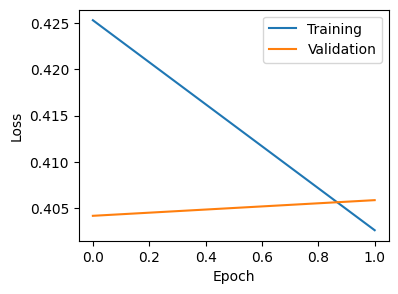

(<__main__.Lightning at 0x7c3f0f16d350>,
 [0.7132326465524927,
  0.704021194124558,
  0.6613545790006453,
  0.7240577627273643,
  0.6724923481425787],
 0.40101868661158546)

In [ ]:
hyperparams = {
    'num_kernels': [30, 30, 30],
    'kernel_size': 12
}
experiment_n_times(hyperparams=hyperparams, model_module=DNA_CNN, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, learning_curve=True, n=1, patience=1)


# Satori

The following is an implementation of the Satori model, which uses convolutional layers followed by multi-headed self-attention layers.
We inserted a few hyperparameters to allow for experimentation and adaptation.
These include: section-specific dropout, architecture of fully connected section, activation of fully connected section, width of post-attention linear output, pooling size, number of attention heads, convolutional layer architecture, and kernel size of the convolutional layers.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random

In [14]:
class CNN_Layers(nn.Module):
    def __init__(self, num_kernels=[8, 32, 32], kernel_size=12,
                 sigma_conv=1e-2, sigma_w=1e-2, dropout=0.2, pool_size=2):
        super(CNN_Layers, self).__init__()
        #self.sigma_conv=sigma_conv
        #self.sigma_w=sigma_w
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.pool_size=pool_size

        self.convs = [self._get_conv_layer(i) for i in range(len(num_kernels))]
        self.conv_block = nn.Sequential(*self.convs)


    def _get_conv_layer(self, layer):
        in_dim = self.num_kernels[layer-1] if layer > 0 else self.input_channels
        out_dim = self.num_kernels[layer]
        return nn.Sequential(
            nn.Conv1d(in_channels=in_dim,
                      out_channels=out_dim,
                      kernel_size=self.kernel_size,
                      padding=self.kernel_size//2),
            nn.ReLU(),
            nn.Dropout(p=self.dropout)
        )

    def forward(self, x):
        # the n, 500, 4 tensor is expected to be of shape n, 4, 500
        x = x.permute(0, 2, 1)
        x = x.float()
        x = self.conv_block(x)
        x = nn.MaxPool1d(self.pool_size)(x)
        return x


In [15]:
class Attention_Layer(nn.Module):
    def __init__(self, seq_length, cnn_filters, num_heads, dropout=0.2, output_dim=10):
        super(Attention_Layer, self).__init__()
        self.d = seq_length
        self.num_heads = num_heads
        self.filters = cnn_filters
        self.dropout = dropout

        # I'm doing all of the attention heads in batch, so the weights are 3D tensors
        self.key_weights = nn.Parameter(torch.randn(num_heads, seq_length, cnn_filters))
        self.query_weights = nn.Parameter(torch.randn(num_heads, seq_length, cnn_filters))
        self.value_weights = nn.Parameter(torch.randn(num_heads, seq_length, cnn_filters))

        self.linear = nn.Linear(num_heads*self.d, output_dim)
        self.relu = nn.ReLU()

    def forward(self, X):
        z = self.get_attention(X)

        # Flattening the heads here is the same as concatenating the attention scores
        batch_size = z.shape[0]
        z= z.permute(0,2,1,3)
        z = z.reshape(batch_size, self.d, -1)

        z = self.transform_and_collapse(z)
        return z

    def get_attention(self, X):
        X = X.transpose(-2, -1)
        '''
        For the einsums
        h: number of heads
        l = d = seq_length (l for length, d for dimension)
        f = filters
        b = batch size
        ----------------
        Result is just matmul with the LHS transposed, but is 4D tensor for the two batch dimensions (databatch and headbatch)
        '''
        keys = torch.einsum('hlf,bdf->bhld', self.key_weights, X)
        queries = torch.einsum('hlf,bdf->bhld', self.query_weights, X)
        values = torch.einsum('hlf,bdf->bhld', self.value_weights, X)

        # Since the shapes were aligned in the einsum, matmul is a straight forward operation and it ignores the two batch dimensions
        attention_scores = torch.matmul(queries, keys.transpose(-2,-1)) / np.sqrt(self.d)
        attention_scores = F.softmax(attention_scores, dim=-1)
        z = nn.Dropout(self.dropout)(attention_scores)

        
        z = torch.matmul(attention_scores, values)
        return z
    
    def transform_and_collapse(self, z):
        z= z.sum(dim=1)
        z = (z - z.mean()) / z.std()
        
        z = self.linear(z)
        #z = self.relu(z)
        return z
    

In [16]:
class Satori(nn.Module):
    def __init__(self, in_length, num_kernels=[8,32,32], kernel_size=12, sigma_conv=1e-2,
                 sigma_w=1e-2, cnn_dropout=0.2, pool_size=6, num_heads=4, attn_dropout=0, attn_out_bandwidth = 10, fully_connected_dropout=0.2, fully_connected_layers=[20, 20], output_dim=5, fully_connected_activation=nn.ReLU, output_activation=nn.Sigmoid):
        super(Satori, self).__init__()
        self.in_length = in_length
        self.d = in_length // pool_size
        
        self.cnn = CNN_Layers(num_kernels, kernel_size, sigma_conv, sigma_w, cnn_dropout, pool_size)
        self.attention = Attention_Layer(self.d, num_kernels[-1], num_heads, dropout=attn_dropout, output_dim=attn_out_bandwidth)
        self.fully_connected = self.get_fully_connected_layers(attn_out_bandwidth, output_dim, fully_connected_layers, fully_connected_activation, fully_connected_dropout)
        self.fully_connected = nn.Sequential(*self.fully_connected)
        self.output_activation = output_activation()

    def forward(self, x):
        # This just helps in the rare case we are not using batches and still want to call for a prediction
        #if len(x.shape) == 2:
        #    x = x.unsqueeze(1)
        x.float()
        if x.shape[1] != self.in_length:
            raise ValueError(f"Input tensor must have shape (n, {self.in_length}, 4) but got {x.shape}")

        x = self.cnn(x)
        x = self.attention(x)
        x = self.fully_connected(x)
        x = self.output_activation(x)
        return x
        
    def get_fully_connected_layers(self, in_dim, out_dim, layers, activation, dropout):
        fc_layers = []
        for i in range(len(layers)):
            fc_layers.append(nn.Linear(in_dim, layers[i]))
            if activation is not None:
                fc_layers.append(activation())
            fc_layers.append(nn.Dropout(p=dropout))
            in_dim = layers[i]
        fc_layers.append(nn.Linear(in_dim, out_dim))
        return fc_layers

Now for the experiments, the code cell below was used repeatedly for ad-hoc tuning of the model.
Below are some well-performing hyperparameters that were found.
In summary of these not shown experiments, we find that the model is very sensitive to a few hyperparameters.
In general, more convolutional kernels and layers are better. The highest tried was [1000,1000,1000].
We find that using fully connected activation and complex fully connected architectures is typically negatively impactful.
Using more attention heads is usually a safe bet.
All of the segments with dropout, were shown to improve performance where the values of 0 ,.2, and .5 were tried. Of these .5 was the best.

Starting experiment 1
training loss: 0.442784
validation loss: 0.603204
training loss: 0.390740
validation loss: 0.551496
Early Stopping
Test loss: 0.711467
AUCs: [0.7487663352445127, 0.723393896796948, 0.6555475206727672, 0.7253242605472592, 0.6908897185179433]


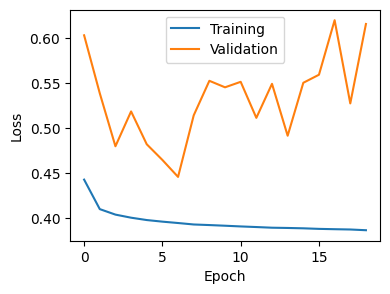

(<__main__.Lightning at 0x7c3f1025c890>,
 [0.7487663352445127,
  0.723393896796948,
  0.6555475206727672,
  0.7253242605472592,
  0.6908897185179433],
 0.711466575434216)

In [22]:
hyperparams = {
    'in_length': 500,
    'num_kernels': [50, 50, 50],
    'kernel_size': 12,
    'pool_size': 5,
    'num_heads': 10,
    'attn_out_bandwidth': 100,
    'fully_connected_layers': [100, 100],
    'fully_connected_activation': None,
    'fully_connected_dropout': 0.5,
    'cnn_dropout': 0.5,
    'attn_dropout': 0.5,
}
experiment_n_times(hyperparams=hyperparams, model_module=Satori, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
, learning_curve=True, n=1, learning_rate=1e-4, patience=12)


Now a grid search on some of the other hyperparameters will be performed.

In [ ]:
layers_to_try = [
    [5,5],
    [100,100,100],
    [300,300,300],
    [50,50,50,50,50]
]
pool_sizes = [5, 10]
num_heads_to_try = [4,8,12]

for layer_try in layers_to_try:
    for pool in pool_sizes:
        for heads in num_heads_to_try:
            hyperparams = {
                'in_length': 500,
                'num_kernels': layer_try,
                'kernel_size': 12,
                'pool_size': pool,
                'num_heads': heads,
                'attn_out_bandwidth': 5,
                'fully_connected_layers': [5],
                'fully_connected_activation': None,
                'fully_connected_dropout': 0.5,
                'cnn_dropout': 0.5,
                'attn_dropout': 0.5,
            }
            print('Trying:', hyperparams)
            experiment_n_times(hyperparams=hyperparams, model_module=Satori, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
            , learning_curve=False, n=1, learning_rate=1e-4, patience=12)

Trying: {'in_length': 500, 'num_kernels': [5, 5], 'kernel_size': 12, 'pool_size': 5, 'num_heads': 4, 'attn_out_bandwidth': 5, 'fully_connected_layers': [5], 'fully_connected_activation': None, 'fully_connected_dropout': 0.5, 'cnn_dropout': 0.5, 'attn_dropout': 0.5}
Starting experiment 1
training loss: 0.568555
validation loss: 0.463903
training loss: 0.426236
validation loss: 0.512707
Early Stopping
Test loss: 0.501137
AUCs: [0.3910414780541043, 0.28432015267256044, 0.3340585898445941, 0.2821314986247941, 0.3707697505474469]
Trying: {'in_length': 500, 'num_kernels': [5, 5], 'kernel_size': 12, 'pool_size': 5, 'num_heads': 8, 'attn_out_bandwidth': 5, 'fully_connected_layers': [5], 'fully_connected_activation': None, 'fully_connected_dropout': 0.5, 'cnn_dropout': 0.5, 'attn_dropout': 0.5}
Starting experiment 1
training loss: 0.525555
validation loss: 0.459736
training loss: 0.424641
validation loss: 0.499462
Early Stopping
Test loss: 0.477324
AUCs: [0.3805434174988447, 0.34237343538161236

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x404 and 400x5)

Unsurprisingly, having very small numbers of convolutional filters does not perform well.
More interestingly, the [100,100,100] architecture performed better overall to the [300,300,300]
Our best performers were the [100,100,100] with low pooling size and high attention heads.

There is not significant evidence here that Satori ourperforms the DeepBind model. It is certainly more sensitive to hyperparameters, and the DeepBind model is more stable.
It may be that with more tuning, Satori could outperform DeepBind, but it is not clear from the results here.

# SEI

This model is based on the following paper: Chen, K.M., Wong, A.K., Troyanskaya, O.G. et al. A sequence-based global map of regulatory activity for deciphering human genetics. Nat Genet 54, 940–949 (2022). https://doi.org/10.1038/s41588-022-01102-2

The Chen et al paper introduced the Sei framework, integrating human genetics data with sequence information to help in the discovery of the regulatory bases of traits and diseases. Sei uses a deep learning model to predict chromatin profiles across cell lines and tissues, providing a global classification and quantification of sequence and variant effects based on diverse regulatory activities. The framework generates sequence classes, which are a vocabulary of regulatory activities, and allows for the systematic classification and scoring of any sequence and variant based on their impact on regulatory activities. The framework was trained on 21,907 cis-regulatory profiles and uses a convolutional network with linear and nonlinear paths, residual dilated convolution layers, and spatial basis function transformation. The framework was applied to study the correlation between enhancer sequence classes and cell type-specific gene expression.

My initial thought, given that the model was trained on BED files and human chromosome data, was that transfer learning might be possible. Unfortunately I was not able to modify the model structure while preserving the weights and complete the training within the time limits of the assignment (though this is still an interesting idea). Scaling back, I instead started with a network with similar architecture in terms of convolutional layers, but without the residual connections and the spatial basis function.

In [27]:
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset

Figure 21 of the supplementary material outlined the model structure as follows:

Input: The model takes an input of size Batch×4×4096.

Convolutional Layers: The input is passed through a series of convolutional layers with different parameters. These convolutional layers have varying numbers of filters (e.g., 480, 640, 960) and kernel shapes (9x9). The convolutional layers are followed by ReLU activation functions.

Max Pooling: After each set of convolutional layers, max pooling is applied with a kernel shape of 4x4 and strides of 4.

Residual Dilated Convolution Layers: The output of the last max pooling layer is passed through a series of residual dilated convolution layers. These layers have varying dilations (2, 4, 8, 16, 25) and kernel shapes (5x5). The dilated convolution layers are followed by ReLU activation functions.

MatMul and Reshape: The output of the last dilated convolution layer is passed through a matrix multiplication (MatMul) operation with a weight matrix of size 256x16. The result is then reshaped.

Linear Layers: The reshaped output is passed through two linear layers. The first linear layer has a weight matrix of size 21907x15360, and the second linear layer has a weight matrix of size 21907x21907. Both linear layers are followed by ReLU activation functions.

Sigmoid Activation: The output of the second linear layer is passed through a sigmoid activation function.

Residual Dual Linear + Nonlinear Paths: The model employs a residual architecture with dual linear and nonlinear paths. This means that the output of the second linear layer is added to the input of the model, creating a residual connection.

Spatial Basis Function and Output Layers: The model uses spatial basis functions, specifically B-splines with a degree-of-freedom of 16. The output layers generate the final predicted cis-regulatory profiles, which have a size of Batch×21907.

In [28]:
class SEIModel2(nn.Module):
    def __init__(self, dropout_rate=0.25, use_bn=True):
        super(SEIModel2, self).__init__()
        self.conv1 = nn.Conv1d(4, 480, kernel_size=9, padding=4)
        self.bn1 = nn.BatchNorm1d(480) if use_bn else nn.Identity()
        self.drop1 = nn.Dropout(dropout_rate)
        
        self.conv2 = nn.Conv1d(480, 640, kernel_size=9, padding=4)
        self.bn2 = nn.BatchNorm1d(640) if use_bn else nn.Identity()
        self.drop2 = nn.Dropout(dropout_rate)
        
        self.conv3 = nn.Conv1d(640, 960, kernel_size=9, padding=4)
        self.bn3 = nn.BatchNorm1d(960) if use_bn else nn.Identity()
        self.drop3 = nn.Dropout(dropout_rate)
        
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.dilated_conv1 = nn.Conv1d(960, 960, kernel_size=5, padding=4, dilation=2)
        self.bn4 = nn.BatchNorm1d(960) if use_bn else nn.Identity()
        self.drop4 = nn.Dropout(dropout_rate)
        
        self.dilated_conv2 = nn.Conv1d(960, 960, kernel_size=5, padding=8, dilation=4)
        self.bn5 = nn.BatchNorm1d(960) if use_bn else nn.Identity()
        self.drop5 = nn.Dropout(dropout_rate)
        
        self.dilated_conv3 = nn.Conv1d(960, 960, kernel_size=5, padding=16, dilation=8)
        self.bn6 = nn.BatchNorm1d(960) if use_bn else nn.Identity()
        self.drop6 = nn.Dropout(dropout_rate)
        
        self.dilated_conv4 = nn.Conv1d(960, 960, kernel_size=5, padding=32, dilation=16)
        self.bn7 = nn.BatchNorm1d(960) if use_bn else nn.Identity()
        self.drop7 = nn.Dropout(dropout_rate)
        
        self.dilated_conv5 = nn.Conv1d(960, 960, kernel_size=5, padding=50, dilation=25)
        self.bn8 = nn.BatchNorm1d(960) if use_bn else nn.Identity()
        self.drop8 = nn.Dropout(dropout_rate)
        
        self.fc1 = nn.Linear(960, 256)
        self.bn9 = nn.BatchNorm1d(256) if use_bn else nn.Identity()
        self.drop9 = nn.Dropout(dropout_rate)
        
        self.output = nn.Linear(256, 5)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reorder dimensions for Conv1d
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.drop1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.drop2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.drop3(x)
        
        x = self.maxpool(x)
        
        x = F.relu(self.bn4(self.dilated_conv1(x)))
        x = self.drop4(x)
        
        x = F.relu(self.bn5(self.dilated_conv2(x)))
        x = self.drop5(x)
        
        x = F.relu(self.bn6(self.dilated_conv3(x)))
        x = self.drop6(x)
        
        x = F.relu(self.bn7(self.dilated_conv4(x)))
        x = self.drop7(x)
        
        x = F.relu(self.bn8(self.dilated_conv5(x)))
        x = self.drop8(x)
        
        x = torch.mean(x, 2)  # Global average pooling over the sequence length
        
        x = F.relu(self.bn9(self.fc1(x)))
        x = self.drop9(x)
        
        x = self.output(x)
        x = torch.sigmoid(x)  # Ensure output is between 0 and 1
        return x


The printout of this SEI(ish) model is as follows:

SEIModel(
  (conv1): Conv1d(4, 480, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv2): Conv1d(480, 640, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv3): Conv1d(640, 960, kernel_size=(9,), stride=(1,), padding=(4,))
  (maxpool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dilated_conv1): Conv1d(960, 960, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
  (dilated_conv2): Conv1d(960, 960, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(4,))
  (dilated_conv3): Conv1d(960, 960, kernel_size=(5,), stride=(1,), padding=(16,), dilation=(8,))
  (dilated_conv4): Conv1d(960, 960, kernel_size=(5,), stride=(1,), padding=(32,), dilation=(16,))
  (dilated_conv5): Conv1d(960, 960, kernel_size=(5,), stride=(1,), padding=(50,), dilation=(25,))
  (fc1): Linear(in_features=960, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=5, bias=True)
)

Obviously the dimensions have been adjusted for the sequence input, and there is an output with sigmoid activations. I left out the residual connections used in the SEI model, with the idea that these could be added if the current model were insufficient.

Prior experiments (omitted here for clarity) established an optimal initial learning rate of 0.0001. Batch sizes of 64, 128 and 256 were tested with minimal changes to the outcome, so this was run with a batch size of 256. 

In [29]:
# slightly revised to allow changes to dropout rate and use/non-use of batch normalization
def experiment_n_times(hyperparams, model_module, dropout_rate, use_bn, X_train, X_test, y_train, y_test, SGD=False, learning_curve=False, n=3, verbose=True):
    """
    Run an experiment multiple times and return the best model, test loss, and test AUC.

    Args:
        hyperparams (dict): Dictionary containing training hyperparameters for the model.
        model_module (module): Module containing the model class.
        dropout_rate (float): Dropout rate to be used in the model.
        use_bn (bool): Flag to indicate the use of batch normalization in the model.
        X_train, X_test, y_train, y_test: Training and testing datasets.
        SGD (bool, optional): Whether to use stochastic gradient descent. Defaults to False.
        learning_curve (bool, optional): Whether to print the learning curve. Defaults to False.
        n (int, optional): Number of times to run the experiment. Defaults to 3.
        verbose (bool, optional): Whether to print verbose output. Defaults to True.

    Returns:
        tuple: Tuple containing the best model instance, test loss, and test AUC.
    """

    class result:
        def __init__(self, model, lightning, accuracy):
            self.model = model
            self.lightning = lightning
            self.val_accuracy = accuracy

    results = []

    for i in range(n):
        print('Starting experiment', i+1)
        model = model_module(dropout_rate=dropout_rate, use_bn=use_bn)  # Instantiate the model with specified configuration
        lightning = Lightning(model, verbose=verbose, lr=hyperparams['learning_rate'])
        if SGD:
            lightning.use_SGD(lr=hyperparams['learning_rate'])

        lightning.train(X_train, y_train, epochs=hyperparams['epochs'], batch_size=hyperparams['batch_size'], validation_size=hyperparams['validation_size'], patience=hyperparams['patience'])
        results.append(result(model, lightning, lightning.final_val_loss()))

    best_result = max(results, key=lambda x: x.val_accuracy)
    best_model_instance = best_result.model
    best_lightning_instance = best_result.lightning
    test_loss, test_auc = best_lightning_instance.test(X_test, y_test)

    if learning_curve:
        best_lightning_instance.print_learning_curve()

    return (best_model_instance, test_loss, test_auc)


In [33]:
# Define hyperparameters common to all experiments
hyperparams = {
    'learning_rate': 0.0001,
    'epochs': 100,
    'batch_size': 256,
    'validation_size': 0.2,
    'patience': 10
}


In [34]:
# Define different configurations for dropout rate and batch normalization
configurations = [
    {'dropout_rate': 0.0, 'use_bn': True},
    {'dropout_rate': 0.0, 'use_bn': False},
    {'dropout_rate': 0.25, 'use_bn': True},
    {'dropout_rate': 0.25, 'use_bn': False},
    {'dropout_rate': 0.5, 'use_bn': True},
    {'dropout_rate': 0.5, 'use_bn': False}
]


Running experiment with dropout rate 0.0 and batch norm True
Starting experiment 1
training loss: 0.407441
validation loss: 0.379245
training loss: 0.255420
validation loss: 0.628446
Early Stopping
Test loss: 1.033745
AUCs: [0.70054528233865, 0.6713514847724872, 0.6355702687036551, 0.6833458297050112, 0.6096844565073641]


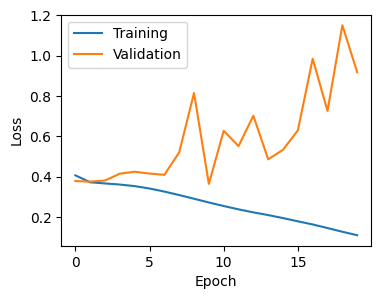

Completed: Avg Loss = 1.0337447470472174, Avg AUC = 0.6600994644054335
Running experiment with dropout rate 0.0 and batch norm False
Starting experiment 1
training loss: 0.438202
validation loss: 0.396584
training loss: 0.341201
validation loss: 0.368047
training loss: 0.215566
validation loss: 0.390793
Early Stopping
Test loss: 0.816935
AUCs: [0.7536898271869388, 0.7175407431591996, 0.6763609058310401, 0.708020065646656, 0.6933965193206026]


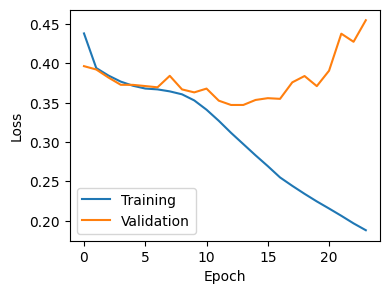

Completed: Avg Loss = 0.816935236849859, Avg AUC = 0.7098016122288874
Running experiment with dropout rate 0.25 and batch norm True
Starting experiment 1
training loss: 0.423608
validation loss: 0.394637
training loss: 0.358763
validation loss: 0.372391
training loss: 0.308159
validation loss: 0.409621
Early Stopping
Test loss: 0.506087
AUCs: [0.7117831110682631, 0.7231612104970513, 0.6909624472443598, 0.7141915784191676, 0.6744981458023531]


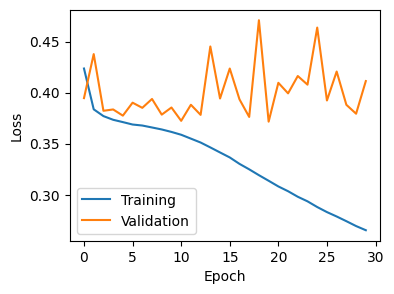

Completed: Avg Loss = 0.5060871267615228, Avg AUC = 0.702919298606239
Running experiment with dropout rate 0.25 and batch norm False
Starting experiment 1
training loss: 0.445340
validation loss: 0.440432
training loss: 0.370752
validation loss: 0.389654
training loss: 0.348959
validation loss: 0.377335
training loss: 0.297405
validation loss: 0.369602
training loss: 0.270090
validation loss: 0.373711
Early Stopping
Test loss: 0.459387
AUCs: [0.7387941549417072, 0.682240498948768, 0.642939646757422, 0.6866376069110083, 0.6627007445031241]


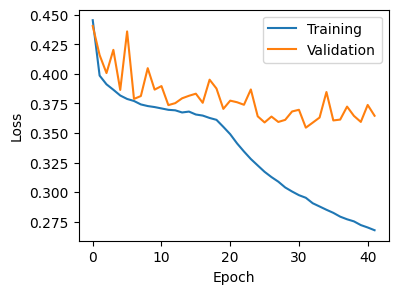

Completed: Avg Loss = 0.4593867419103832, Avg AUC = 0.6826625304124059
Running experiment with dropout rate 0.5 and batch norm True
Starting experiment 1
training loss: 0.453657
validation loss: 1.939735
training loss: 0.373155
validation loss: 2.483228
Early Stopping
Test loss: 2.587858
AUCs: [0.7177618160364732, 0.6644773738851025, 0.644797747252672, 0.6982840309981917, 0.6802063587102174]


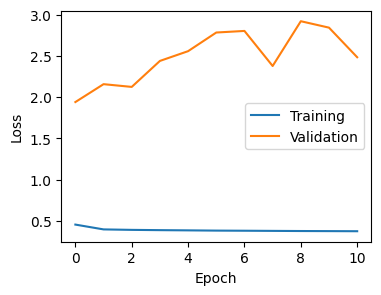

Completed: Avg Loss = 2.587857840480157, Avg AUC = 0.6811054653765313
Running experiment with dropout rate 0.5 and batch norm False
Starting experiment 1
training loss: 0.451733
validation loss: 0.487876
training loss: 0.380470
validation loss: 0.445896
training loss: 0.373959
validation loss: 0.453536
Early Stopping
Test loss: 0.464130
AUCs: [0.6463696867936866, 0.6030122239788335, 0.5816754660144169, 0.6846105089127656, 0.5964114524622846]


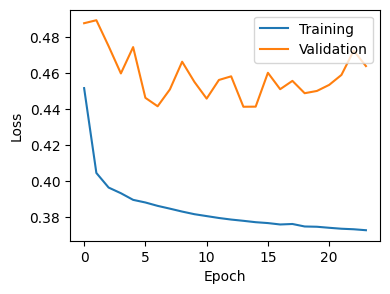

Completed: Avg Loss = 0.46412963579807964, Avg AUC = 0.6224158676323974
Best Configuration: Dropout Rate = 0.0, Batch Norm = Disabled
Best Average Loss = 0.816935236849859, Best Average AUC = 0.7098016122288874


In [37]:
# Initialize dictionary to store all results
all_results = {(config['dropout_rate'], config['use_bn']): [] for config in configurations}
results = {}  # Initialize an empty dictionary to store averaged results

# number of runs of each experiment
n_runs = 1  # ideally there would be a higher number, but in the interest of having the run complete before the deadline....

# Run experiments for each configuration
for config in configurations:
    dropout_rate = config['dropout_rate']
    use_bn = config['use_bn']
    print(f"Running experiment with dropout rate {dropout_rate} and batch norm {use_bn}")
    
    # Collect results from multiple runs
    for _ in range(n_runs):
        _, test_loss, test_auc = experiment_n_times(
            hyperparams=hyperparams,
            model_module=SEIModel2,  
            dropout_rate=dropout_rate,
            use_bn=use_bn,
            X_train=X_train,
            X_test=X_test,
            y_train=y_train,
            y_test=y_test,
            n=1,  # Always 1 as we're manually looping for multiple runs
            learning_curve=True  
        )
        
        # Calculate the mean AUC if it's a list
        mean_test_auc = sum(test_auc) / len(test_auc) if isinstance(test_auc, list) else test_auc
        
        # Append results from this run to the list
        all_results[(dropout_rate, use_bn)].append((test_loss, mean_test_auc))
    
    # Calculate average results after all runs
    avg_loss = sum(res[0] for res in all_results[(dropout_rate, use_bn)]) / len(all_results[(dropout_rate, use_bn)])
    avg_auc = sum(res[1] for res in all_results[(dropout_rate, use_bn)]) / len(all_results[(dropout_rate, use_bn)])
    
    # Store averaged results
    results[(dropout_rate, use_bn)] = (avg_loss, avg_auc)
    print(f"Completed: Avg Loss = {avg_loss}, Avg AUC = {avg_auc}")

# Determine the best configuration based on average AUC
best_config, best_metrics = max(results.items(), key=lambda x: x[1][1])
print(f"Best Configuration: Dropout Rate = {best_config[0]}, Batch Norm = {'Enabled' if best_config[1] else 'Disabled'}")
print(f"Best Average Loss = {best_metrics[0]}, Best Average AUC = {best_metrics[1]}")



I suspect with refinement (as in, 10 runs instead of 1) that the actual best performance would be with a Dropout Rate of 0.25 and Batch Norm disabled, given the training graph and test set loss, but the AUCs for most of the runs were very close. Further refinements to the network could include adding the recurrent connections and the matmul layer, though this might make the issue of overfitting worse. Regarding the obvious overfitting that occurs consistently ~10 epochs, another avenue would be the additional of some gaussian noise during training (taking care that it does not prevent training entirely). 

# Conclusions



We found that, in general, this task is difficult for machine learning models to perform well on.
The DeepBind model provided a good benchmark and was relatively stable.
Satori struggled to outperform DeepBind, and when not tuned well, performed worse.
The SEI model was able to performed well compared to DeepBind. It was able to regularly beat the performance of DeepBind, but not consistently or by a large margin.